## Python Dependencies

In [22]:
import os
from datetime import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler, ConcatDataset, Subset, Dataset
from torchvision import datasets
from IPython import get_ipython
from IPython.display import clear_output, display, update_display
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri(uri="http://localhost:8080")

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % (2**32 - 1)
    np.random.seed(worker_seed)

def before_cell_run(info):
    set_seed(42)

ip = get_ipython()
ip.events.register('pre_run_cell', before_cell_run)

## Load and Preprocessing Data

In [ ]:
import concurrent.futures
def save_sample(idx, dataset):
    image, label = dataset
    label_dir = os.path.join(dataset_dir, str(label).zfill(3))
    os.makedirs(label_dir, exist_ok=True)

    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    image = torch.clamp(image, 0, 1)
    image_pil = transforms.ToPILImage()(image)

    image_filename = os.path.join(label_dir, f'{label}_{str(idx).zfill(5)}.jpg')
    image_pil.save(image_filename)

def save_dataset_multithread(dataset, dataset_name):
    global dataset_dir
    dataset_dir = os.path.join('./', dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)

    dataset_indices = list(range(len(dataset)))

    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        list(executor.map(save_sample, dataset_indices, dataset))

In [4]:
def data_preprocess(batch_size=32, transform_train=None, transform_test=None):
    if transform_train is None:
        # Define the random transforms for data augmentation
        transform_train_augmented = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Define the original transforms without random augmentations
        transform_train_original = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        transform_train_augmented = transform_train_original = transform_train

    if transform_test is None:
        transform_test = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # Load the original train dataset without random transforms
    train_dataset_original = datasets.Flowers102(
        root='./data', split='test', download=True, transform=transform_train_original
    )

    # Load the augmented train dataset with random transforms
    train_dataset_augmented = datasets.Flowers102(
        root='./data', split='test', download=True, transform=transform_train_augmented
    )

    # Merge the original and augmented datasets
    train_dataset = ConcatDataset([train_dataset_original, train_dataset_augmented])

    # Load validation and test datasets
    val_dataset = datasets.Flowers102(
        root='./data', split='val', download=True, transform=transform_test
    )
    test_dataset = datasets.Flowers102(
        root='./data', split='train', download=True, transform=transform_test
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn
    )

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset


train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = data_preprocess()

images, labels = next(iter(train_loader))
print(f"訓練集中的圖像尺寸: {images.shape}, 對應標籤: {labels.shape}")
print(len(train_dataset), len(test_dataset), len(val_dataset))

訓練集中的圖像尺寸: torch.Size([32, 3, 224, 224]), 對應標籤: torch.Size([32])
12298 1020 1020


### Label Balancing

In [17]:
def plot_labels_distribution(dataset, title):
    labels = [label for _, label in dataset]
    label_counter = Counter(labels)
    labels, counts = zip(*label_counter.items())

    plt.figure(figsize=(10, 3))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

    return label_counter

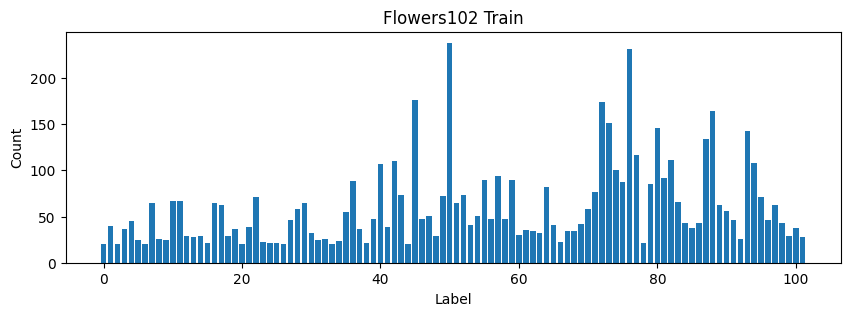

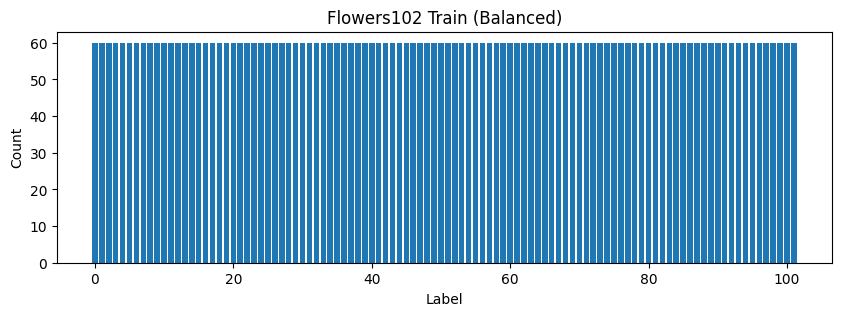

In [23]:
transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_train_augmented = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.3, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

flowers102_train = datasets.ImageFolder(root='./flowers102_train', transform=transform_normal)
counter = plot_labels_distribution(flowers102_train, 'Flowers102 Train')
average_count = int(sum(counter.values()) / len(counter))
balanced_indices = []
augmented_samples = []

for label, count in counter.items():
    indices = [i for i, (_, lbl) in enumerate(flowers102_train.samples) if lbl == label]
    
    if count < average_count:
        balanced_indices.extend(indices)
        required_samples = average_count - count
        for _ in range(required_samples):
            idx = random.choice(indices)
            img_path, _ = flowers102_train.samples[idx]
            image = flowers102_train.loader(img_path)
            augmented_image = transform_train_augmented(image)
            augmented_samples.append((augmented_image, label))
    elif count > average_count:
        sampled_indices = random.sample(indices, average_count)
        balanced_indices.extend(sampled_indices)
    else:
        balanced_indices.extend(indices)

balanced_dataset = Subset(flowers102_train, balanced_indices)

class AugmentedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

augmented_dataset = AugmentedDataset(augmented_samples)
final_dataset = ConcatDataset([balanced_dataset, augmented_dataset])
balanced_counter = plot_labels_distribution(final_dataset, 'Flowers102 Train (Balanced)')

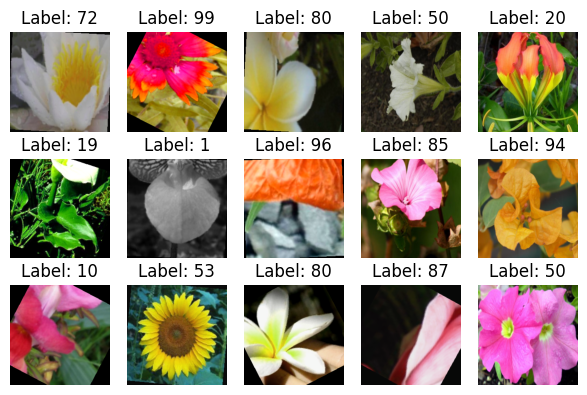

In [5]:
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# 將前 15 張圖片解正規化並顯示
fig, axes = plt.subplots(3, 5, figsize=(6, 4))
axes = axes.flatten()

for i in range(15):
    image = inv_normalize(images[i])  # 解正規化
    image = image.permute(1, 2, 0).numpy()  # 調整維度以符合 matplotlib 的顯示格式
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model Definition

In [6]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, activation_function=nn.ReLU):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = activation_function(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out
    
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, activation_function=nn.ReLU):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = activation_function(inplace=True)
        self.stride = stride
        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels * 4:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

In [7]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model_name = 'SimpleNet'
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 102)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def simple_net():
    return Net()

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102, activation_function=nn.ReLU, initialize_weights=True, model_name='ResNet'):
        super(ResNet, self).__init__()
        self.model_name = model_name
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], activation_function=activation_function)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2, activation_function=activation_function)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2, activation_function=activation_function)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2, activation_function=activation_function)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.initialize_weights = initialize_weights
        if initialize_weights:
            self.apply(self._initialize_weights)

    def make_layer(self, block, out_channels, blocks, stride=1, activation_function=nn.ReLU):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, activation_function))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            _b = block(self.in_channels, out_channels, 1, activation_function)
            layers.append(_b)
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

def resnet18(num_classes=102, activation_function=nn.ReLU, initialize_weights=True):
    model_name = f'ResNet18-{activation_function.__name__}'
    return ResNet(
        ResidualBlock, [2, 2, 2, 2], 
        num_classes=num_classes, 
        activation_function=activation_function, 
        initialize_weights=initialize_weights, 
        model_name=model_name
    )

def resnet34(num_classes=102, activation_function=nn.ReLU, initialize_weights=True):
    model_name = f'ResNet34-{activation_function.__name__}'
    return ResNet(
        ResidualBlock, [3, 4, 6, 3], 
        num_classes=num_classes, 
        activation_function=activation_function, 
        initialize_weights=initialize_weights, 
        model_name=model_name
    )

def resnet50(num_classes=102, activation_function=nn.ReLU, initialize_weights=True):
    model_name = f'ResNet50-{activation_function.__name__}'
    return ResNet(
        BottleneckBlock, [3, 4, 6, 3], 
        num_classes=num_classes, 
        activation_function=activation_function, 
        initialize_weights=initialize_weights, 
        model_name=model_name
    )

def resnet101(num_classes=102, activation_function=nn.ReLU, initialize_weights=True):
    model_name = f'ResNet101-{activation_function.__name__}'
    return ResNet(
        BottleneckBlock, [3, 4, 23, 3], 
        num_classes=num_classes, 
        activation_function=activation_function, 
        initialize_weights=initialize_weights, 
        model_name=model_name
    )

def resnet152(num_classes=102, activation_function=nn.ReLU, initialize_weights=True):
    model_name = f'ResNet152-{activation_function.__name__}'
    return ResNet(
        BottleneckBlock, [3, 8, 36, 3], 
        num_classes=num_classes, 
        activation_function=activation_function, 
        initialize_weights=initialize_weights, 
        model_name=model_name
    )

In [9]:
def resnet18_p(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    model.pretrained = pretrained
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    return model

def resnet34_p(pretrained=False):
    model = models.resnet34(pretrained=pretrained)
    model.pretrained = pretrained
    if pretrained:
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 102)
    return model

def resnet50_p(pretrained=False):
    model = models.resnet50(pretrained=pretrained)
    model.pretrained = pretrained
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    return model

def resnet101_p(pretrained=False):
    model = models.resnet101(pretrained=pretrained)
    model.pretrained = pretrained
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    return model

def resnet152_p(pretrained=False):
    model = models.resnet152(pretrained=pretrained)
    model.pretrained = pretrained
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    return model



## Helper Functions

In [10]:
def identify_resnet_version(model):
    layers = [len(model.layer1), len(model.layer2), len(model.layer3), len(model.layer4)]

    print(model.layer1[0].__class__.__name__)
    exit(1)

    if layers == [2, 2, 2, 2]:
        return "ResNet18"
    elif layers == [3, 4, 6, 3] and model.layer1[0].__class__.__name__ == 'BasicBlock':
        return "ResNet34"
    elif layers == [3, 4, 6, 3] and model.layer1[0].__class__.__name__ == 'Bottleneck':
        return "ResNet50"
    elif layers == [3, 4, 23, 3]:
        return "ResNet101"
    elif layers == [3, 8, 36, 3]:
        return "ResNet152"
    else:
        return "Unknown ResNet version"
    
def identify_has_pretrained(model):
    return hasattr(model, 'pretrained') and model.pretrained

def train_info(model, epochs, criterion, optimizer, scheduler, device):
    model_name = model.model_name if hasattr(model, 'model_name') else identify_resnet_version(model) + ('-pretrained' if identify_has_pretrained(model) else '')

    return {
        'model_name': model_name,
        'has_kaiming_initialize': model.initialize_weights if hasattr(model, 'initialize_weights') else False,
        'epochs': epochs,
        'criterion': criterion.__class__.__name__,
        'optimizer': optimizer.__class__.__name__,
        'lr': optimizer.param_groups[0].get('lr', 0),
        'momentum': optimizer.param_groups[0].get('momentum', 0),
        'weight-decay': optimizer.param_groups[0].get('weight_decay', 0),
        'scheduler': scheduler.__class__.__name__ if scheduler is not None else None,
        'scheduler_step_size': scheduler.step_size if hasattr(scheduler, 'step_size') else None,
        'scheduler_gamma': scheduler.gamma if hasattr(scheduler, 'gamma') else None,
        'scheduler_mode': scheduler.mode if hasattr(scheduler, 'mode') else None,
        'scheduler_factor': scheduler.factor if hasattr(scheduler, 'factor') else None,
        'scheduler_patience': scheduler.patience if hasattr(scheduler, 'patience') else None,
        'scheduler_T_max': scheduler.T_max if hasattr(scheduler, 'T_max') else None,
        'device': device.type
    }

In [11]:
from matplotlib.ticker import MaxNLocator

def live_plot(values={}, params={}):
    start_time = params.get('start_time', datetime.now())
    time = start_time.strftime('%Y-%m-%d %H:%M:%S')
    filename_time = start_time.strftime('%Y%m%d%H%M%S')

    model_name = params.get('model_name', 'ResNet')
    has_kaiming_initialize = params.get('has_kaiming_initialize', False)
    epochs = params.get('epochs', 0)
    criterion = params.get('criterion', 'N/A')
    optimizer = params.get('optimizer', 'N/A')
    lr = params.get('lr', 'N/A')
    momentum = params.get('momentum', None)
    weight_decay = params.get('weight-decay', None)
    scheduler = params.get('scheduler', None)
    scheduler_step_size = params.get('scheduler_step_size', None)
    scheduler_gamma = params.get('scheduler_gamma', None)
    scheduler_mode = params.get('scheduler_mode', None)
    scheduler_factor = params.get('scheduler_factor', None)
    scheduler_patience = params.get('scheduler_patience', None)
    scheduler_T_max = params.get('scheduler_T_max', None)
    test_model = params.get('test_model', False)
    batch_size = params.get('batch_size', 0)
    remarks = params.get('remarks', None)
    device = params.get('device', 'cpu')

    title = f'{model_name} Training/Test Loss and Accuracy'
    info_text = f'Epochs: {epochs}\nBatch Size: {batch_size}\n{device}\n{criterion}\n{optimizer}, LR: {lr}'
    scheduler_file_text = scheduler if scheduler is not None else 'None'
    if weight_decay is not None and weight_decay > 0:
        info_text += f'\nWD: {weight_decay}'
    if momentum is not None and float(momentum) > 0:
        info_text += f'\nMomentum: {momentum}'
    if scheduler is not None:
        info_text += f'\nScheduler: {scheduler}'
        if scheduler == 'ReduceLROnPlateau':
            scheduler_file_text = f'{scheduler_file_text}_{scheduler_mode}_{scheduler_factor}_{scheduler_patience}'
            info_text += f'\n- M: {scheduler_mode}, F: {scheduler_factor}, P: {scheduler_patience}'
        elif scheduler == 'StepLR':
            scheduler_file_text = f'{scheduler_file_text}_{scheduler_step_size}_{scheduler_gamma}'
            info_text += f'\n- S: {scheduler_step_size}, G: {scheduler_gamma}'
        elif scheduler == 'CosineAnnealingLR':
            scheduler_file_text = f'{scheduler_file_text}_{scheduler_T_max}'
            info_text += f'\n- T_max: {scheduler_T_max}'
    if has_kaiming_initialize:
        info_text += '\nKaiming Init: Y'
    if remarks is not None:
        info_text += f'\n{remarks}'

    filename = f"{model_name.replace(' ', '_')}_{epochs}_{batch_size}_{has_kaiming_initialize}_{criterion}_{optimizer}_{lr}_{momentum}_{weight_decay}_{scheduler_file_text}_{filename_time}.png"

    loss_values = values.get('loss_values', [])
    test_loss_values = values.get('test_loss_values', [])
    val_loss_values = values.get('val_loss_values', [])
    val_acc_values = values.get('val_acc_values', [])
    lr_values = values.get('lr_values', [])
    acc_values = values.get('acc_values', [])
    test_values = values.get('test_values', [])

    for epoch in range(epochs):
        early_stop = params.get('early_stop', False)
        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        plt.subplots_adjust(left=0.12, right=0.95, wspace=0.3)
        ax1.plot(range(1, len(loss_values)+1), loss_values, 'r-o', label='Train Loss')
        ax1.plot(range(1, len(val_loss_values)+1), val_loss_values, 'b-^', label='Val Loss')
        ax1.plot(range(1, len(test_loss_values)+1), test_loss_values, 'g-x', label='Test Loss')
        ax1.set_title('Training/Val/Test Loss & Learning Rate')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax1_lr = ax1.twinx()
        ax1_lr.plot(range(1, len(lr_values)+1), lr_values, 'y-', label='Learning Rate')
        ax1_lr.set_ylabel('Learning Rate')
        ax1_lr.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax1_lr.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax1_lr.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax1_lr.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

        ax2.plot(range(1, len(acc_values)+1), acc_values, 'r-x', label='Train Accuracy')
        ax2.plot(range(1, len(val_acc_values)+1), val_acc_values, 'b-^', label='Val Accuracy')
        ax2.plot(range(1, len(test_values)+1), test_values, 'g-o', label='Test Accuracy')
        ax2.set_title('Training/Val/Test Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.legend()

        fig.suptitle(title, fontsize=16)

        cost_time = datetime.now() - start_time
        cost_time_text = f'{cost_time.seconds // 60}m {cost_time.seconds % 60}s'
        if early_stop:
            cost_time_text += ' (Early Stopped)'
        acc_text = f'Train Acc: {acc_values[-1]:.4f}, Test Acc: {test_values[-1]:.4f}'
        best_acc_text = f'Best Test Acc: {max(test_values):.4f} in Epoch {test_values.index(max(test_values)) + 1}'
        plt.figtext(0.01, 0.96, f'{epoch + 1} / {epochs} Epochs, cost {cost_time_text}', fontsize=10, ha='left', color='red')
        plt.figtext(0.01, 0.03, info_text, fontsize=10, ha='left', bbox=dict(facecolor='lightgrey', alpha=0.5, edgecolor='black'))
        plt.figtext(0.99, 0.01, time, fontsize=10, ha='right')
        plt.figtext(0.99, 0.96, acc_text, fontsize=9, ha='right', color='blue')
        plt.figtext(0.99, 0.93, best_acc_text, fontsize=9, ha='right', color='green')

        if not test_model:
            plt.savefig(filename)
        plt.show()

        yield filename

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


## Training and Evaluation Functions

In [13]:
def train(model, train_loader, criterion, optimizer, device, epochs=5, scheduler=None, test_model=False, valid_loader=None, early_stopping=None):
    model.train()
    if test_model:
        return random.random() * 100 + 1, random.random() * 100 + 1, random.random() * 0.001, 0, random.random() * 100 + 1, random.random() * 100 + 1
    running_loss = 0.0
    total = 0
    correct = 0
    lr = optimizer.param_groups[0].get('lr', 0)
    
    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation loop
    if valid_loader is not None:
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for val_images, val_labels in valid_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss_batch = criterion(val_outputs, val_labels)
                val_loss += val_loss_batch.item()

                _, val_preds = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_preds == val_labels).sum().item()

        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
    else:
        val_loss = None
        val_acc = None

    # Scheduler step based on validation loss
    if scheduler:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau) and valid_loader is not None:
            if scheduler.mode == 'min':
                scheduler.step(val_loss)
            elif scheduler.mode == 'max':
                scheduler.step(val_acc)
        else:
            scheduler.step()
        lr = scheduler.get_last_lr()[0]

    if early_stopping is not None:
        early_stopping(val_loss)
        if early_stopping.early_stop:
            return train_loss, train_acc, lr, val_loss, val_acc, True

    return train_loss, train_acc, lr, val_loss, val_acc, False


In [14]:
def test(model, test_loader, criterion, device, test_model=False):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    if test_model:
        return random.random(), random.random()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    return loss/len(test_loader), correct/total, (all_labels, all_preds, all_probs)

In [15]:
# try_model defined in this cell

if torch.cuda.is_available(): # Nvidia GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # Apple Silicon M series
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def try_model(model, criterion=None, optimizer=None, epochs=5, train_loader=train_loader, test_loader=test_loader, val_loader=None, scheduler=None, test_model=False, batch_size=32, remarks=None, experiment_name="DeepLearning Training"):
    start_time = datetime.now()
    train_acc_values = []
    train_loss_values = []
    val_acc_values = []
    val_loss_values = []
    lr_values = []
    test_acc_values = []
    test_loss_values = []
    info = train_info(model, epochs, criterion, optimizer, scheduler, device)
    info['start_time'] = start_time
    info['test_model'] = test_model
    info['batch_size'] = batch_size
    info['remarks'] = remarks
    info['early_stop'] = False
    plotter = live_plot({
        'acc_values': train_acc_values,
        'loss_values': train_loss_values,
        'val_acc_values': val_acc_values,
        'val_loss_values': val_loss_values,
        'lr_values': lr_values,
        'test_values': test_acc_values,
        'test_loss_values': test_loss_values
    }, info)

    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    mlflow.set_experiment(experiment_name)
    best_acc = 0
    filename = None
    with mlflow.start_run():
        model = model.to(device)
        early_stopping = EarlyStopping(patience=20, min_delta=0.001)
        mlflow.log_params(info)
        for epoch in range(epochs):
            loss, acc, lr, val_loss, val_acc, early_stop = train(model, train_loader, criterion, optimizer, device, epochs, scheduler, test_model, val_loader, early_stopping)
            info['early_stop'] = early_stop
            train_loss_values.append(loss)
            train_acc_values.append(acc)
            val_loss_values.append(val_loss)
            val_acc_values.append(val_acc)
            lr_values.append(lr)
            test_loss, test_acc, _ = test(model, test_loader, criterion, device, test_model)
            test_acc_values.append(test_acc)
            test_loss_values.append(test_loss)

            mlflow.log_metric('train_loss', loss, step=epoch)
            mlflow.log_metric('train_acc', acc, step=epoch)
            mlflow.log_metric('val_loss', val_loss, step=epoch)
            mlflow.log_metric('val_acc', val_acc, step=epoch)
            mlflow.log_metric('lr', lr, step=epoch)
            mlflow.log_metric('test_loss', test_loss, step=epoch)
            mlflow.log_metric('test_acc', test_acc, step=epoch)
            mlflow.log_metric('early_stop', early_stop)

            if test_acc > best_acc:
                best_acc = test_acc
                mlflow.pytorch.log_model(model, f"best_model_{info['model_name']}")

            mlflow.log_metric('best_test_acc', best_acc)

            filename = next(plotter)

            if early_stop:
                break
        mlflow.log_artifact(filename)
        mlflow.end_run()

    return best_acc

## Training

### Parameters Grid Search

In [35]:
import itertools

param_grid = {
    'model': [resnet18, resnet34, resnet50, resnet101, resnet152, resnet18_p, resnet34_p, resnet50_p, resnet101_p, resnet152_p],
    'activation_function': [nn.ReLU, nn.LeakyReLU, nn.SiLU, nn.ELU],
    'criterion': [nn.CrossEntropyLoss],
    'optimizer': [optim.SGD, optim.NAdam, optim.Adam, optim.AdamW],
    'epochs': [125],
    
    'scheduler': [optim.lr_scheduler.ReduceLROnPlateau],
    'batch_size': [16, 32, 64],
    'lr': [0.001, 0.0005, 0.0001],
    'momentum': [0.9, 0.95],
    'weight_decay': [0.0001, 0.0005, 0.001],
    'kiming_initialize': [True, False],
    
    'scheduler_mode': ['min', 'max'],
    'scheduler_factor': [0.1, 0.3],
    'scheduler_patience': [3, 5, 7, 10],
}
param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

276480

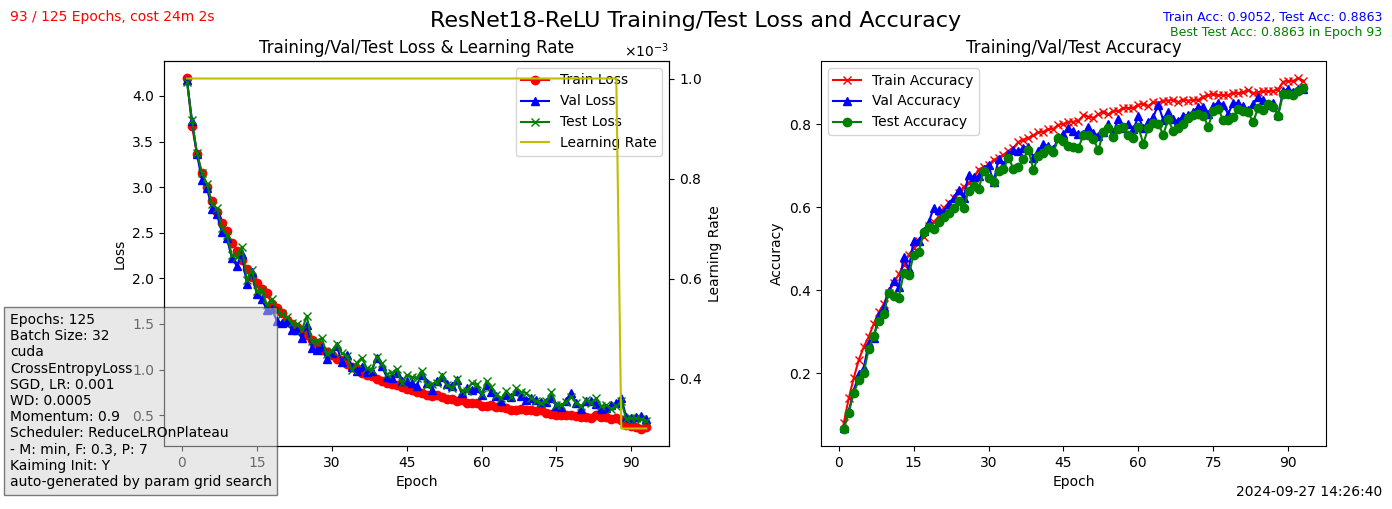

In [19]:
start_index = 0
for idx, params in enumerate(param_combinations):
    if idx < start_index:
        continue

    model = params[0]()
    activation_function = params[1]
    criterion = params[2]()
    if params[3] == optim.SGD:
        optimizer = params[3](model.parameters(), lr=params[7], momentum=params[8], weight_decay=params[9])
    else:
        optimizer = params[3](model.parameters(), lr=params[7], weight_decay=params[9])
    epochs = params[4]
    scheduler = params[5](optimizer, mode=params[10], factor=params[11], patience=params[12])
    batch_size = params[6]
    remarks = f"auto-generated by param grid search"
    train_loader, val_loader, test_loader, _, _, _ = data_preprocess(batch_size=batch_size)
    try:
        try_model(model, criterion, optimizer, epochs, train_loader, test_loader, val_loader, scheduler, test_model=False, batch_size=batch_size, remarks=remarks)
    except Exception as e:
        print(f"Error: {e}")
        with open('error_log.txt', 'a') as f:
            f.write(f"index: {idx}, Params: {params}\n\n")
        continue

### ResNet18

In [148]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

random_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

special_train_dataset_normal = datasets.ImageFolder(root='./flowers102_train', transform=transform)
special_train_dataset_random = datasets.ImageFolder(root='./flowers102_train', transform=random_transform)
special_train_dataset = ConcatDataset([special_train_dataset_normal, special_train_dataset_random])

all_samples = []
for dataset in special_train_dataset.datasets:
    all_samples.extend(dataset.samples)

label_counts = Counter([label for _, label in all_samples])
sample_weights = [1.0 / label_counts[label] for _, label in all_samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(special_train_dataset), replacement=True)
s_t_loader = DataLoader(special_train_dataset, batch_size=32, sampler=sampler, num_workers=4, worker_init_fn=worker_init_fn)
# s_t_loader = DataLoader(special_train_dataset, batch_size=32, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

print(len(special_train_dataset))

12298


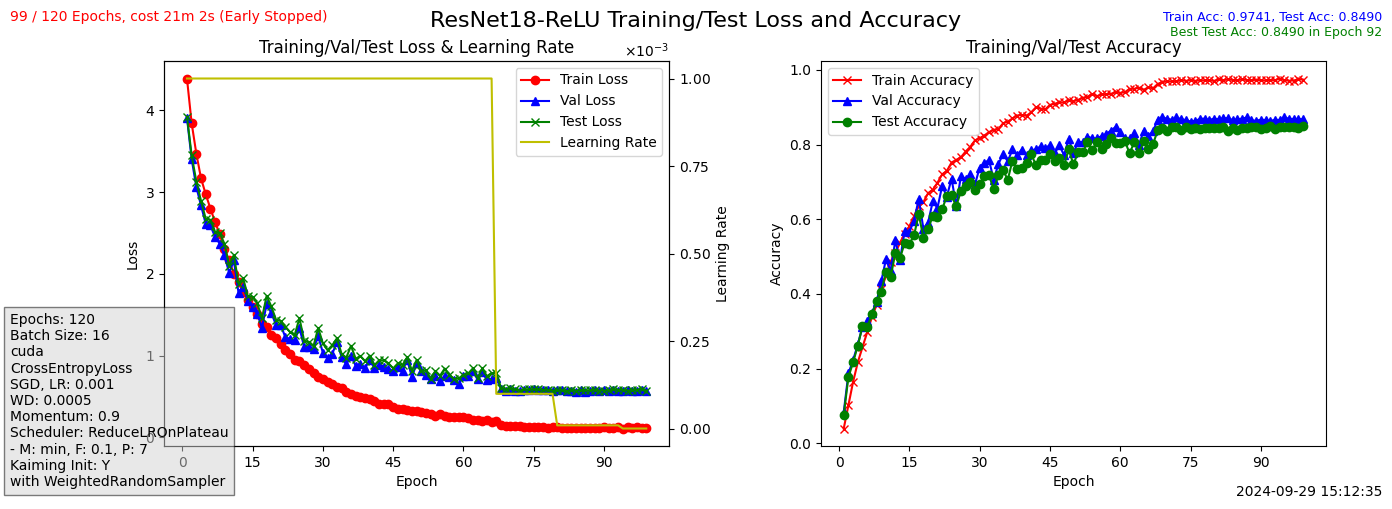

2024/09/29 15:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-swan-685 at: http://localhost:8080/#/experiments/599447659728708801/runs/39cfe504e530460cbaf8722476ef56e2.
2024/09/29 15:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/599447659728708801.


0.8490196078431372

In [149]:
# Unrun
BATCH_SIZE = 16
train_loader, val_loader, test_loader, _ , _ , _  = data_preprocess(batch_size=BATCH_SIZE)
model = resnet18(activation_function=nn.ReLU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1)
try_model(
    model,
    criterion=criterion ,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=120,
    batch_size=BATCH_SIZE,
    train_loader=s_t_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    test_model=False,
    experiment_name="Balanced_data training",
    remarks="with WeightedRandomSampler"
)

/tmp/ipykernel_2803514/2112230899.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(buffer)


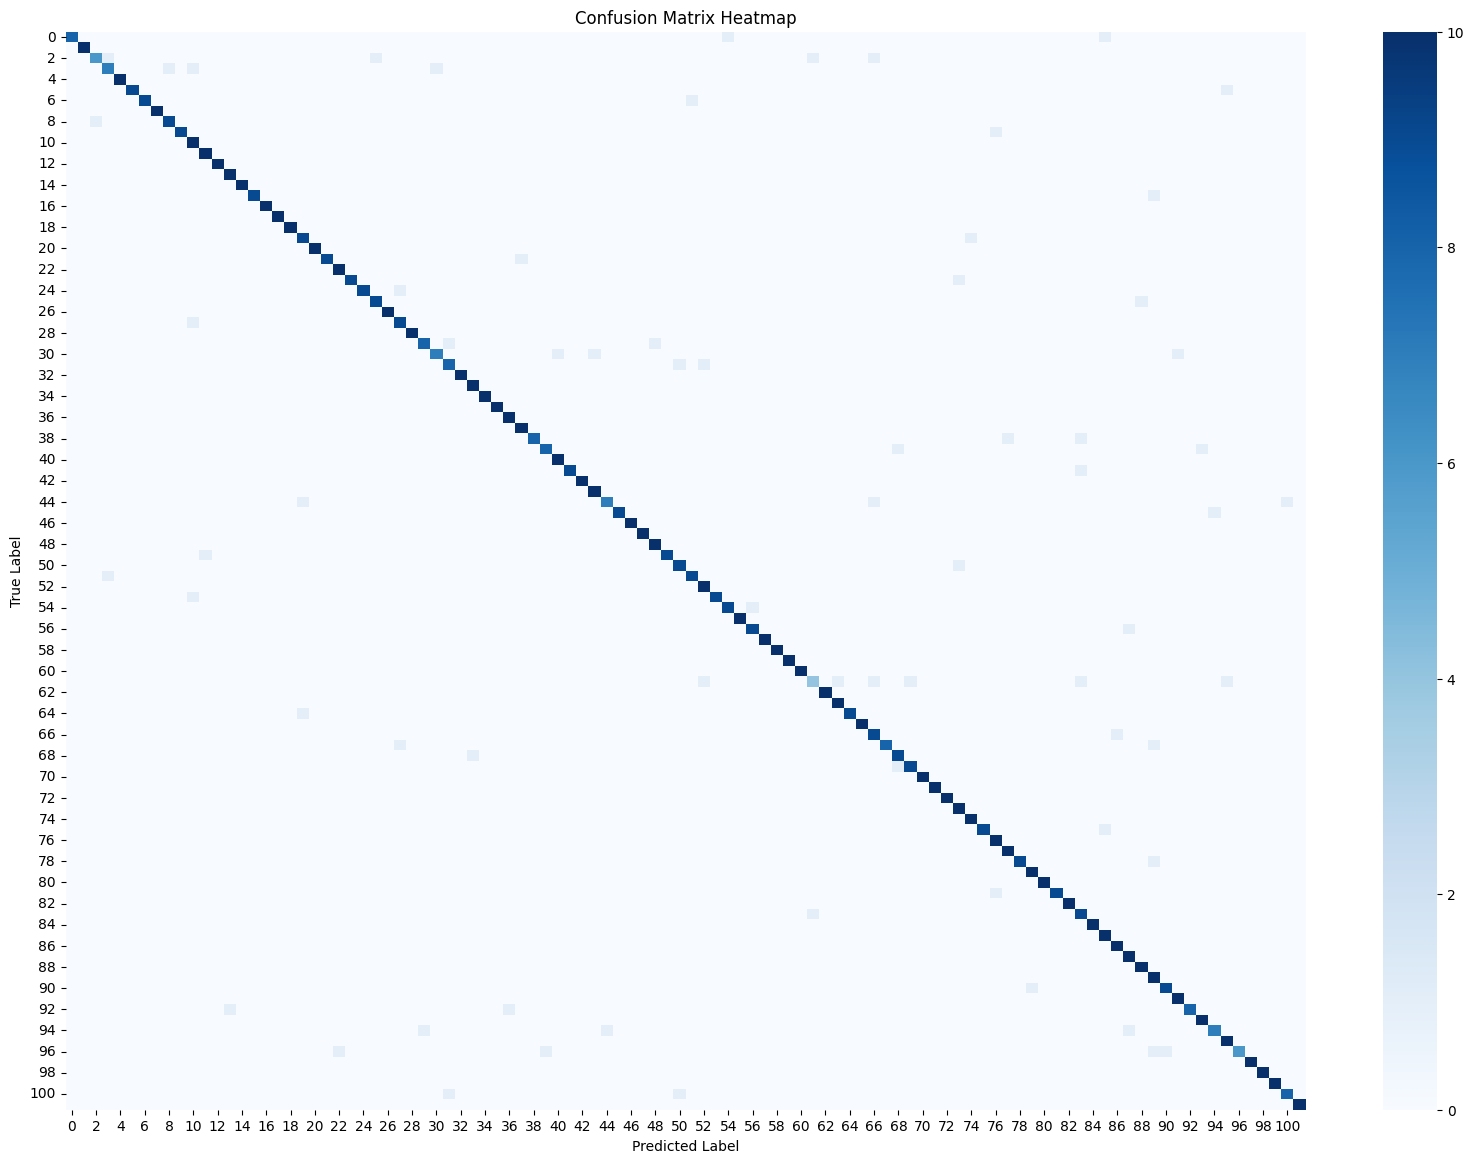

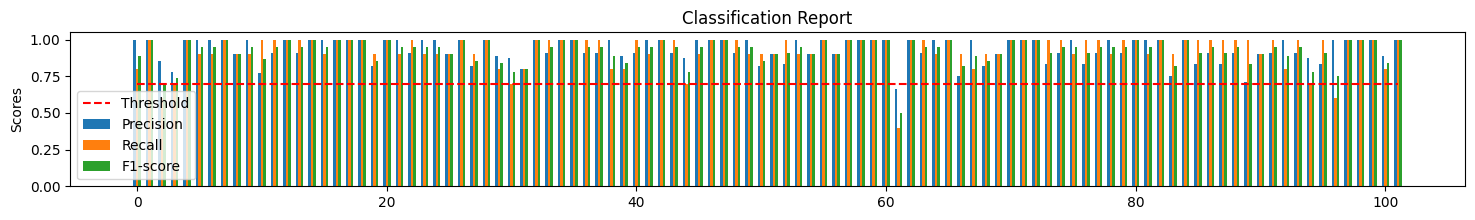

In [38]:
import io

with open('mlartifacts/599447659728708801/2fbc11dad25947b28352a2e1e0710492/artifacts/best_model_ResNet18-ReLU/data/model.pth', 'rb') as f:
    buffer = io.BytesIO(f.read())

model = torch.load(buffer)
acc, loss, (all_labels, all_preds, all_probs) = test(model, test_loader, criterion, device)
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 14))
sns.heatmap(conf_matrix, annot=False, cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./assets/confusion_matrix_heatmap.png')
plt.show()
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, output_dict=True)
precision = []
recall = []
f1_score = []
labels = []
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        labels.append(label)
        precision.append(metrics['precision'])
        recall.append(metrics['recall'])
        f1_score.append(metrics['f1-score'])
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(18, 2))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')
ax.plot(x, [0.7] * len(labels), 'r--', label='Threshold')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()
plt.savefig('./assets/classification_report.png')
plt.show()